notes on 2020.1.21:
- 23.5 k cases: rain coverage >= 10%, median threat score: 0.53
- 8.1 k cases: rain coverage >= 20%, median threat score: 0.61


note on 2020.3.19:
- output "/Users/jiang/data/jma_radar/dt_threat_2020_1_21.joblib", key = dt, value = threat score
- "rain_coverage_2019.joblib" is produced by use_dailyJoblib_check_rain_coverage.ipynb
- above 2 data has been combined to output: "threat_coverage.csv"

In [135]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta

import joblib
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
pick_file  = f"rain_continue_collection.joblib"
pick_path = os.path.join(data_folder, pick_file)
larger10_first, larger20_first, _, _ = joblib.load(pick_path)

/Users/jiang/github_all/rainymotion/docs/notebooks


In [136]:
%%time
tot = 365*288 # 105120
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt_threat = {}  # datetime: threat score
# initialize

dt0  = datetime(2019,1,1,0,0)
model = models.Dense60()
daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)

for i in range(tot-13):  
    dt = dt0 + timedelta(seconds = time_step*i)
    yday_str = dt.strftime('%Y_%m_%d')
    if larger10_first[i]:  # count of true value is 23508        
        dt_now = dt + timedelta(seconds = time_step)
        dt_12  = dt + timedelta(seconds = time_step * 13)
        yday_now = dt_now.strftime('%Y_%m_%d')
        yday_12 =  dt_12.strftime('%Y_%m_%d')
        
        if yday_str not in daily_database:
            daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib")) # (288,1000,1000)
        if yday_12 not in daily_database:
            daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) # (288,1000,1000)

        #sequence_in_day = int(dt.hour*12 + (dt.minute)/5)
        #sequence_in_day = i % 288
        inputs[0,:,:] = daily_database[yday_str][  i  %288]/10.0   # back to original scale
        inputs[1,:,:] = daily_database[yday_now][(i+1)%288]/10.0
        gt_in_60_min =  daily_database[yday_12][(i+13)%288]/10.0
        model.input_data = inputs
        nowcast = model.run()  
        dt_threat[dt] = metrics.CSI(gt_in_60_min, nowcast, threshold = threshold)
        
    # release memory in dict
    if (i+1) % 288 == 0:  # last one in a day
        if yday_str in daily_database:
            del daily_database[yday_str] 
    if i % 10000 == 0:
        print(yday_str,end = ",")
        
# Wall time: 4h 13min 59s

2019_01_01,2019_02_04,2019_03_11,2019_04_15,2019_05_19,2019_06_23,2019_07_28,2019_09_01,2019_10_05,2019_11_09,2019_12_14,CPU times: user 18h 8min 46s, sys: 47min 19s, total: 18h 56min 5s
Wall time: 4h 13min 59s


In [137]:
data_folder = "/Users/jiang/data/jma_radar"
data_file  = f"dt_threat_2020_1_21.joblib"
data_path = os.path.join(data_folder,data_file)
joblib.dump(dt_threat,data_path)

['/Users/jiang/data/jma_radar/dt_threat_2020_1_21.joblib']

In [138]:
rain_year = joblib.load (os.path.join(data_folder, f"rain_coverage_2019.joblib"))
rain_year_1D = rain_year.flatten()
larger10_coverage = rain_year_1D[rain_year_1D>=10]

## convert to panda dataframe and do data analysis

In [145]:
import pandas as pd
data = pd.DataFrame.from_dict(dt_threat, orient='index', columns=['threat'])
data.index.name = 'datetime'
data.reset_index(inplace=True)
data['coverage'] = larger10_coverage
data['yday'] = data['datetime'].apply(lambda x: x.timetuple().tm_yday)

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23508 entries, 0 to 23507
Data columns (total 4 columns):
datetime    23508 non-null datetime64[ns]
threat      23508 non-null float64
coverage    23508 non-null float64
yday        23508 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 734.8 KB


In [146]:
data.head()

,datetime,threat,coverage,yday
0,2019-01-04 15:20:00,0.318602,10.031250,4
1,2019-01-04 15:25:00,0.343380,10.281250,4
2,2019-01-04 15:30:00,0.333484,10.531250,4
3,2019-01-04 15:35:00,0.337191,10.781250,4
4,2019-01-04 15:40:00,0.373808,10.984375,4


In [147]:
np.median(data.threat), np.median(data.threat[data.coverage >= 20])

(0.5320959358816131, 0.6171085027732206)

In [161]:
np.mean(data.threat), np.mean(data.threat[data.coverage >= 20])

(0.5326755306934359, 0.6108358032004607)

In [148]:
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data.to_csv(csv_path, index = False)

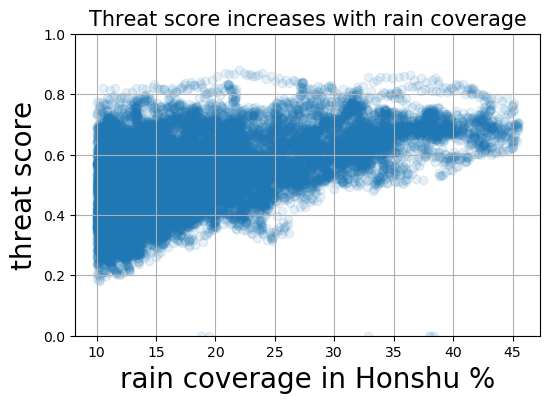

In [164]:
plt.figure(dpi=100)
plt.scatter(data.coverage, data.threat, alpha = 0.1)
plt.title("Threat score increases with rain coverage",fontsize= 15)
plt.xlabel("rain coverage in Honshu %",fontsize= 20)
plt.ylabel("threat score",fontsize= 20)
plt.ylim([0,1])
plt.grid()
plt.show()

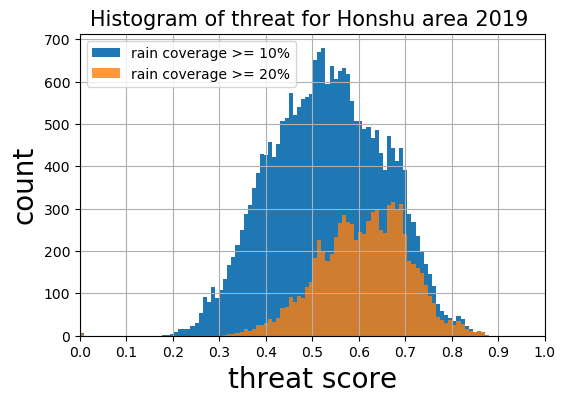

In [171]:
plt.figure(dpi = 100)
plt.hist(data.threat,100, label = "rain coverage >= 10%")
plt.hist(data.threat[data.coverage >= 20],100, label = "rain coverage >= 20%")
plt.legend()
plt.title("Histogram of threat for Honshu area 2019 ",fontsize= 15)
plt.xlabel("threat score",fontsize= 20)
plt.ylabel("count",fontsize= 20)
plt.xticks(np.linspace(0,1,11))
plt.xlim([0,1])
plt.grid()
plt.show()

## indepedent recovery

In [1]:
import os
import pandas as pd
data_folder = "/Users/jiang/data/jma_radar"
data_file  = "threat_coverage.csv"
data_path = os.path.join(data_folder,data_file)
data = pd.read_csv(data_path)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23508 entries, 0 to 23507
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  23508 non-null  object 
 1   threat    23508 non-null  float64
 2   coverage  23508 non-null  float64
 3   yday      23508 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 734.8+ KB


In [4]:
data.tail()

,datetime,threat,coverage,yday
23503,2019-12-31 00:10:00,0.301776,10.226562,365
23504,2019-12-31 00:15:00,0.279844,10.078125,365
23505,2019-12-31 00:20:00,0.267715,10.000000,365
23506,2019-12-31 00:30:00,0.269701,10.015625,365
23507,2019-12-31 00:35:00,0.242161,10.007812,365


In [8]:
from datetime import datetime
datetime.now().timetuple().tm_yday

79

In [26]:
d1 = pd.DataFrame({"datetime":datetime.now(),
                   "threat": 0.5,
                  "coverage": 20,
                  'yday':datetime.now().timetuple().tm_yday},index = [data.shape[0]])
data1 = data.append(d1, ignore_index = False)

In [17]:
pd.DataFrame({"datetime":datetime.now(),
                   "threat": 0.5,
                  "coverage": 20,
                  'yday': datetime.now().timetuple().tm_yday},index = [0])

,datetime,threat,coverage,yday
0,2020-03-19 15:10:14.355739,0.5,20,79


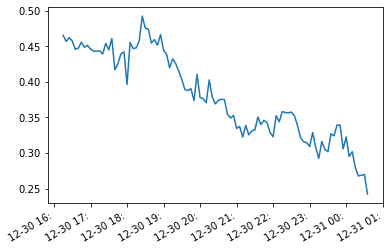

In [50]:
import matplotlib.dates as mdates
dates = data.datetime.apply(lambda x:datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
plt.plot(dates[-100:],data.threat[-100:])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:')) # 格式化时间轴标注
plt.gcf().autofmt_xdate() # 优化标注（自动倾斜）
plt.show()